In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
product = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")


In [3]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [4]:
order_items = pd.merge(order_items, product[
        ["product_id", "product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]],
                           on="product_id")
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,650.0,28.0,9.0,14.0


In [5]:
# calculate order information based on the products inside
order_items = order_items.groupby(["order_id", "seller_id", "product_id"])[
        ["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]].sum()
order_items.reset_index(inplace=True)
order_items.head()

,order_id,seller_id,product_id,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,4244733e06e7ecb4970a6e2683c13e61,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,e5f2d52b802189ee658865ca93d83a8f,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,c777355d18b72b67abbeef9df44fd0fd,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,7634da152a4610f1595efa32f14722fc,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,ac6c3623068f30de03045865e4e10089,3750.0,35.0,40.0,30.0


In [6]:
# include shippment time information
orders = pd.merge(orders, order_items[
        ["order_id", "product_id", "seller_id", "product_weight_g", "product_length_cm", "product_height_cm",
         "product_width_cm"]], on="order_id")
# include cutomer location information
orders = pd.merge(orders,
                          customers[["customer_id", "customer_city", "customer_state", "customer_zip_code_prefix"]],
                          on="customer_id")
# unify the logitude and latitude of each zip code, so that can merger 
geolocation = geolocation.groupby("geolocation_zip_code_prefix").agg(
        {"geolocation_lat": "mean", "geolocation_lng": "mean"})
geolocation.reset_index(inplace=True)

orders = pd.merge(orders, geolocation, left_on="customer_zip_code_prefix",
                          right_on="geolocation_zip_code_prefix")
orders.rename(
        columns={"geolocation_lat": "customer_geolocation_lat", "geolocation_lng": "customer_geolocation_lng"},
        inplace=True)


In [7]:
# include seller location
orders = pd.merge(orders, sellers[["seller_id", "seller_city", "seller_state", "seller_zip_code_prefix"]],
                          on="seller_id")
orders = pd.merge(orders, geolocation, left_on="seller_zip_code_prefix",
                          right_on="geolocation_zip_code_prefix")
orders.rename(
        columns={"geolocation_lat": "seller_geolocation_lat", "geolocation_lng": "seller_geolocation_lng"},
        inplace=True)
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,customer_zip_code_prefix,geolocation_zip_code_prefix_x,customer_geolocation_lat,customer_geolocation_lng,seller_city,seller_state,seller_zip_code_prefix,geolocation_zip_code_prefix_y,seller_geolocation_lat,seller_geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,3149,3149,-23.576983,-46.587161,maua,SP,9350,9350,-23.680729,-46.444238
1,de01100645b731556de153cfbebc35b1,94602ee2b2723266d391c94e7d1f4d89,delivered,2017-08-07 12:13:26,2017-08-07 12:43:37,2017-08-08 13:32:49,2017-08-17 18:24:38,2017-08-29 00:00:00,725cbfcaff95a4d43742fdf13cf43c75,3504c0cb71d7fa48d967e0e4c94d59d9,...,35400,35400,-20.391011,-43.507047,maua,SP,9350,9350,-23.680729,-46.444238
2,e55fb3457f263ce9c93e88a934d7cc17,f185f0c103eaf4cdb003c5fd33d29a9c,delivered,2017-09-06 09:52:11,2017-09-06 10:05:16,2017-09-08 16:14:11,2017-09-16 16:19:28,2017-09-19 00:00:00,5a419dbf24a8c9718fe522b81c69f61a,3504c0cb71d7fa48d967e0e4c94d59d9,...,13186,13186,-22.889982,-47.198980,maua,SP,9350,9350,-23.680729,-46.444238
3,1f201b2bf1eecbd0ad32c3f430846b84,856f3263eb7af3a48765c85d4d0eea1d,delivered,2017-09-26 21:32:17,2017-09-26 21:49:42,2017-09-28 15:28:03,2017-10-03 13:38:04,2017-10-11 00:00:00,725cbfcaff95a4d43742fdf13cf43c75,3504c0cb71d7fa48d967e0e4c94d59d9,...,5782,5782,-23.651294,-46.766853,maua,SP,9350,9350,-23.680729,-46.444238
4,88407c8c6e12493ff6e845df39540112,e902cb9d9992a69a267f69dec57aa3a3,delivered,2017-08-15 02:03:01,2017-08-15 02:15:13,2017-08-16 15:52:29,2017-08-25 21:59:26,2017-08-28 00:00:00,b00a32a0b42fd65efb58a5822009f629,3504c0cb71d7fa48d967e0e4c94d59d9,...,13060,13060,-22.931980,-47.111841,maua,SP,9350,9350,-23.680729,-46.444238


In [8]:
orders = orders.dropna()

In [9]:
# filter the data
# We need to remove the orders with more than one product and only keep the orders with only one product
# Because the given delivery time is based on the last product's delivery time and if there are many products
# in one order and were delivered at different time, the delivery time is not accurate for the first product.
single_order_index = orders["order_id"].value_counts()[orders["order_id"].value_counts() == 1].index
orders = orders[orders.order_id.isin(single_order_index)]
orders.reset_index(drop=True, inplace=True)
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,customer_zip_code_prefix,geolocation_zip_code_prefix_x,customer_geolocation_lat,customer_geolocation_lng,seller_city,seller_state,seller_zip_code_prefix,geolocation_zip_code_prefix_y,seller_geolocation_lat,seller_geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,3149,3149,-23.576983,-46.587161,maua,SP,9350,9350,-23.680729,-46.444238
1,de01100645b731556de153cfbebc35b1,94602ee2b2723266d391c94e7d1f4d89,delivered,2017-08-07 12:13:26,2017-08-07 12:43:37,2017-08-08 13:32:49,2017-08-17 18:24:38,2017-08-29 00:00:00,725cbfcaff95a4d43742fdf13cf43c75,3504c0cb71d7fa48d967e0e4c94d59d9,...,35400,35400,-20.391011,-43.507047,maua,SP,9350,9350,-23.680729,-46.444238
2,e55fb3457f263ce9c93e88a934d7cc17,f185f0c103eaf4cdb003c5fd33d29a9c,delivered,2017-09-06 09:52:11,2017-09-06 10:05:16,2017-09-08 16:14:11,2017-09-16 16:19:28,2017-09-19 00:00:00,5a419dbf24a8c9718fe522b81c69f61a,3504c0cb71d7fa48d967e0e4c94d59d9,...,13186,13186,-22.889982,-47.198980,maua,SP,9350,9350,-23.680729,-46.444238
3,1f201b2bf1eecbd0ad32c3f430846b84,856f3263eb7af3a48765c85d4d0eea1d,delivered,2017-09-26 21:32:17,2017-09-26 21:49:42,2017-09-28 15:28:03,2017-10-03 13:38:04,2017-10-11 00:00:00,725cbfcaff95a4d43742fdf13cf43c75,3504c0cb71d7fa48d967e0e4c94d59d9,...,5782,5782,-23.651294,-46.766853,maua,SP,9350,9350,-23.680729,-46.444238
4,88407c8c6e12493ff6e845df39540112,e902cb9d9992a69a267f69dec57aa3a3,delivered,2017-08-15 02:03:01,2017-08-15 02:15:13,2017-08-16 15:52:29,2017-08-25 21:59:26,2017-08-28 00:00:00,b00a32a0b42fd65efb58a5822009f629,3504c0cb71d7fa48d967e0e4c94d59d9,...,13060,13060,-22.931980,-47.111841,maua,SP,9350,9350,-23.680729,-46.444238


In [10]:
# only keep delivered orders
orders = orders[orders["order_status"] == "delivered"]
# convert time columns to datetime type
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])


In [11]:
# remove orders that are delivered before approved
approve_before_index = orders[orders["order_approved_at"] >= orders["order_delivered_customer_date"]].index
orders = orders[~orders.index.isin(approve_before_index)]
orders.reset_index(drop=True, inplace=True)
# purchase made at which day of the week and month may also affect the delivery time
# so we make new columns for these two feature
orders["day_name"] = orders["order_purchase_timestamp"].apply(lambda x: x.day_name())
orders["purchase_month"] = orders["order_purchase_timestamp"].apply(lambda x: x.month)
# time taken from purchase to delivered
orders["order_completion_day"] = [
        (pd.to_datetime(d.strftime("%Y-%m-%d")) - pd.to_datetime(t.strftime("%Y-%m-%d"))).days
        for d, t in zip(orders["order_delivered_customer_date"], orders["order_purchase_timestamp"])]
# calculate distance
orders["euclidean_distance"] = (np.sqrt(((orders["customer_geolocation_lat"] - orders["seller_geolocation_lat"]) ** 2) +
                                          ((orders["customer_geolocation_lng"] - orders["seller_geolocation_lng"]) ** 2)))


In [12]:
# numerical features
numerical_features = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'order_completion_day', 'euclidean_distance']
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92741 entries, 0 to 92740
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       92741 non-null  object        
 1   customer_id                    92741 non-null  object        
 2   order_status                   92741 non-null  object        
 3   order_purchase_timestamp       92741 non-null  datetime64[ns]
 4   order_approved_at              92741 non-null  datetime64[ns]
 5   order_delivered_carrier_date   92741 non-null  datetime64[ns]
 6   order_delivered_customer_date  92741 non-null  datetime64[ns]
 7   order_estimated_delivery_date  92741 non-null  datetime64[ns]
 8   product_id                     92741 non-null  object        
 9   seller_id                      92741 non-null  object        
 10  product_weight_g               92741 non-null  float64       
 11  product_length_

may need some graph to support this statement. 
From the graph we can see that the delivery performance is very unstable.
Orders under the same condition may have completely different shipping time, which makes it impossible to build a model that can predict the exact delivery date.
Therefore, instead of predicting the exact delivery time of a product, we decides to split the shipping time to several categories and take this as the target we will predict.


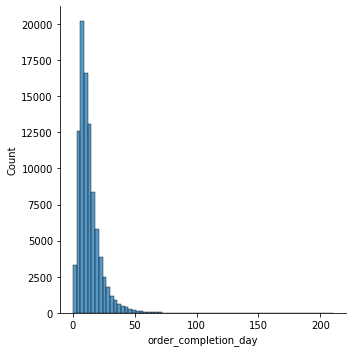

In [13]:
# may need a box plot also

sns.displot(orders, x="order_completion_day", binwidth=3)

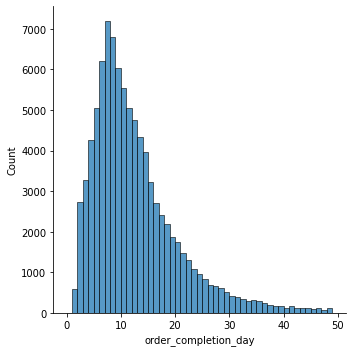

In [14]:
# we can see that most orders are complete within 50 days, and we take a closer look at the orders within 50 days.
x_axis = [i for i in range(50)]
sns.displot(orders, x="order_completion_day", bins=x_axis)
# In order to split these orders fairly, we decides to use k means to determin the 6 categroies.

In [15]:

model = KMeans(n_clusters=10, random_state=42)
k_mean_data = orders[numerical_features+['order_id']]
ss = StandardScaler()
for col in numerical_features:
    if col != "order_completion_day":
        k_mean_data[col] = ss.fit_transform(k_mean_data[[col]])
# here we only consider orders delivered within 30 days, since this covers most of the orders and the range is not too big.
k_mean_data = k_mean_data[orders["order_completion_day"]<30].groupby("order_completion_day").agg({"order_id": "count", 'product_weight_g': "mean", 'product_length_cm':"mean", 'product_height_cm':"mean", 'product_width_cm':"mean", "euclidean_distance": "mean"}).rename(columns={"order_id": "count"})

model.fit(k_mean_data[['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'euclidean_distance']])
cat = model.predict(k_mean_data[['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'euclidean_distance']])
k_mean_data["category"] = cat

In [16]:
k_mean_data

,count,product_weight_g,product_length_cm,product_height_cm,product_width_cm,euclidean_distance,category
order_completion_day,,,,,,,
0,1,-0.161630,-0.089362,0.673232,0.581805,-0.991895,4
1,597,-0.170289,-0.205683,-0.107859,-0.129561,-0.938358,0
2,2729,-0.175623,-0.129304,-0.134458,-0.126325,-0.921407,0
3,3281,-0.101758,-0.087825,-0.071031,-0.062159,-0.822191,7
4,4257,-0.099890,-0.104882,-0.048555,-0.068406,-0.712947,7
5,5058,-0.102026,-0.071743,-0.053395,-0.051221,-0.597536,7
6,6208,-0.056884,-0.042039,-0.040554,-0.020234,-0.451571,2
7,7195,-0.049813,-0.032107,-0.024232,-0.036884,-0.315804,2
8,6806,-0.035355,-0.028259,-0.018086,0.004853,-0.182170,2


From the k means table we can see that the category is usually split by 3 days. Therefore, we generalize the delivery days as following.

In [17]:
orders.loc[(orders["order_completion_day"] >= 0)&(orders["order_completion_day"] <=2), "target"] = "0-2"
orders.loc[(orders["order_completion_day"] >= 3)&(orders["order_completion_day"] <=5), "target"] = "3-5"
orders.loc[(orders["order_completion_day"] >= 6)&(orders["order_completion_day"] <=8), "target"] = "6-8"
orders.loc[(orders["order_completion_day"] >= 9)&(orders["order_completion_day"] <=11), "target"] = "9-11"
orders.loc[(orders["order_completion_day"] >= 12)&(orders["order_completion_day"] <=14), "target"] = "12-14"
orders.loc[(orders["order_completion_day"] >= 15)&(orders["order_completion_day"] <=17), "target"] = "15-17"
orders.loc[(orders["order_completion_day"] >= 18)&(orders["order_completion_day"] <=20), "target"] = "18-20"
orders.loc[(orders["order_completion_day"] >= 21)&(orders["order_completion_day"] <=23), "target"] = "21-23"
orders.loc[(orders["order_completion_day"] >= 24)&(orders["order_completion_day"] <=26), "target"] = "24-26"
orders.loc[(orders["order_completion_day"] >= 27)&(orders["order_completion_day"] <=29), "target"] = "27-29"
orders.loc[orders["order_completion_day"] >= 30, "target"] = "30+"
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,seller_state,seller_zip_code_prefix,geolocation_zip_code_prefix_y,seller_geolocation_lat,seller_geolocation_lng,day_name,purchase_month,order_completion_day,euclidean_distance,target
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,SP,9350,9350,-23.680729,-46.444238,Monday,10,8,0.176608,6-8
1,de01100645b731556de153cfbebc35b1,94602ee2b2723266d391c94e7d1f4d89,delivered,2017-08-07 12:13:26,2017-08-07 12:43:37,2017-08-08 13:32:49,2017-08-17 18:24:38,2017-08-29,725cbfcaff95a4d43742fdf13cf43c75,3504c0cb71d7fa48d967e0e4c94d59d9,...,SP,9350,9350,-23.680729,-46.444238,Monday,8,10,4.410140,9-11
2,e55fb3457f263ce9c93e88a934d7cc17,f185f0c103eaf4cdb003c5fd33d29a9c,delivered,2017-09-06 09:52:11,2017-09-06 10:05:16,2017-09-08 16:14:11,2017-09-16 16:19:28,2017-09-19,5a419dbf24a8c9718fe522b81c69f61a,3504c0cb71d7fa48d967e0e4c94d59d9,...,SP,9350,9350,-23.680729,-46.444238,Wednesday,9,10,1.093122,9-11
3,1f201b2bf1eecbd0ad32c3f430846b84,856f3263eb7af3a48765c85d4d0eea1d,delivered,2017-09-26 21:32:17,2017-09-26 21:49:42,2017-09-28 15:28:03,2017-10-03 13:38:04,2017-10-11,725cbfcaff95a4d43742fdf13cf43c75,3504c0cb71d7fa48d967e0e4c94d59d9,...,SP,9350,9350,-23.680729,-46.444238,Tuesday,9,7,0.323955,6-8
4,88407c8c6e12493ff6e845df39540112,e902cb9d9992a69a267f69dec57aa3a3,delivered,2017-08-15 02:03:01,2017-08-15 02:15:13,2017-08-16 15:52:29,2017-08-25 21:59:26,2017-08-28,b00a32a0b42fd65efb58a5822009f629,3504c0cb71d7fa48d967e0e4c94d59d9,...,SP,9350,9350,-23.680729,-46.444238,Tuesday,8,10,1.003155,9-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92736,4442d1fdf454197e9e141f0d83a9031e,3c3c45651f50bb4b13a4de268cad02b0,delivered,2017-02-03 18:08:16,2017-02-04 07:01:55,2017-02-20 10:49:53,2017-03-01 11:24:45,2017-03-06,7cb009e2ae1cdf7d16e8fbf0255ba953,45a3d05fb00435e52a28859dd03703b3,...,SP,7176,7176,-23.409620,-46.386426,Friday,2,26,11.789703,24-26
92737,a37e262a26000281d0ade3b4eb1ce1e6,d0602b514179e7ed50e801cc02769bac,delivered,2018-08-06 23:14:27,2018-08-06 23:25:19,2018-08-07 14:16:00,2018-08-13 19:08:40,2018-08-22,987ae6d6e94a608f9ea32bc82a649470,466222e777149751370e7e98fb623b0c,...,RJ,20931,20931,-22.880477,-43.217723,Monday,8,7,8.650095,6-8
92738,c31010ef2672e6bae06cf6e265b98138,aa8fe6fdddb25648793aab5b07e5f73d,delivered,2017-02-17 03:09:22,2017-02-17 03:15:08,2017-02-17 07:29:02,2017-02-20 14:44:16,2017-03-23,5f348c2c79eb5d1eea867e7903fce1ee,740205fedfe4e90ca6857bc77db0f2b4,...,SP,95055,95055,-29.151062,-51.142925,Friday,2,3,7.274729,3-5
92739,5c533da06d7dfe10d9d44dbcc8bdbc6b,1285e7456591a89200ad22c4015c09ea,delivered,2017-07-02 13:10:36,2017-07-02 13:25:09,2017-07-07 17:39:39,2017-07-26 22:53:20,2017-08-02,80d63636780c5975e5c93b63236d481d,c8143b3069f6746a77421b5ce30a450c,...,GO,75345,75345,-16.767063,-49.438089,Sunday,7,24,15.923998,24-26


Then we can check the accuracy of the given order_estimated_delivery_date. First we convert the given estimated delivery date into the categories we got from k means.

In [18]:
orders["estimated_completion_day"] = [
        (pd.to_datetime(d.strftime("%Y-%m-%d")) - pd.to_datetime(t.strftime("%Y-%m-%d"))).days
        for d, t in zip(orders["order_estimated_delivery_date"], orders["order_purchase_timestamp"])]
orders.loc[(orders["estimated_completion_day"] >= 0) & (orders["estimated_completion_day"] <= 2), "given_prediction"] = "0-2"
orders.loc[(orders["estimated_completion_day"] >= 3) & (orders["estimated_completion_day"] <= 5), "given_prediction"] = "3-5"
orders.loc[(orders["estimated_completion_day"] >= 6) & (orders["estimated_completion_day"] <= 8), "given_prediction"] = "6-8"
orders.loc[(orders["estimated_completion_day"] >= 9) & (orders["estimated_completion_day"] <= 11), "given_prediction"] = "9-11"
orders.loc[(orders["estimated_completion_day"] >= 12) & (orders["estimated_completion_day"] <= 14), "given_prediction"] = "12-14"
orders.loc[(orders["estimated_completion_day"] >= 15) & (orders["estimated_completion_day"] <= 17), "given_prediction"] = "15-17"
orders.loc[(orders["estimated_completion_day"] >= 18) & (orders["estimated_completion_day"] <= 20), "given_prediction"] = "18-20"
orders.loc[(orders["estimated_completion_day"] >= 21) & (orders["estimated_completion_day"] <= 23), "given_prediction"] = "21-23"
orders.loc[(orders["estimated_completion_day"] >= 24) & (orders["estimated_completion_day"] <= 26), "given_prediction"] = "24-26"
orders.loc[(orders["estimated_completion_day"] >= 27) & (orders["estimated_completion_day"] <= 29), "given_prediction"] = "27-29"
orders.loc[orders["estimated_completion_day"] >= 30, "given_prediction"] = "30+"
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,geolocation_zip_code_prefix_y,seller_geolocation_lat,seller_geolocation_lng,day_name,purchase_month,order_completion_day,euclidean_distance,target,estimated_completion_day,given_prediction
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,9350,-23.680729,-46.444238,Monday,10,8,0.176608,6-8,16,15-17
1,de01100645b731556de153cfbebc35b1,94602ee2b2723266d391c94e7d1f4d89,delivered,2017-08-07 12:13:26,2017-08-07 12:43:37,2017-08-08 13:32:49,2017-08-17 18:24:38,2017-08-29,725cbfcaff95a4d43742fdf13cf43c75,3504c0cb71d7fa48d967e0e4c94d59d9,...,9350,-23.680729,-46.444238,Monday,8,10,4.410140,9-11,22,21-23
2,e55fb3457f263ce9c93e88a934d7cc17,f185f0c103eaf4cdb003c5fd33d29a9c,delivered,2017-09-06 09:52:11,2017-09-06 10:05:16,2017-09-08 16:14:11,2017-09-16 16:19:28,2017-09-19,5a419dbf24a8c9718fe522b81c69f61a,3504c0cb71d7fa48d967e0e4c94d59d9,...,9350,-23.680729,-46.444238,Wednesday,9,10,1.093122,9-11,13,12-14
3,1f201b2bf1eecbd0ad32c3f430846b84,856f3263eb7af3a48765c85d4d0eea1d,delivered,2017-09-26 21:32:17,2017-09-26 21:49:42,2017-09-28 15:28:03,2017-10-03 13:38:04,2017-10-11,725cbfcaff95a4d43742fdf13cf43c75,3504c0cb71d7fa48d967e0e4c94d59d9,...,9350,-23.680729,-46.444238,Tuesday,9,7,0.323955,6-8,15,15-17
4,88407c8c6e12493ff6e845df39540112,e902cb9d9992a69a267f69dec57aa3a3,delivered,2017-08-15 02:03:01,2017-08-15 02:15:13,2017-08-16 15:52:29,2017-08-25 21:59:26,2017-08-28,b00a32a0b42fd65efb58a5822009f629,3504c0cb71d7fa48d967e0e4c94d59d9,...,9350,-23.680729,-46.444238,Tuesday,8,10,1.003155,9-11,13,12-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92736,4442d1fdf454197e9e141f0d83a9031e,3c3c45651f50bb4b13a4de268cad02b0,delivered,2017-02-03 18:08:16,2017-02-04 07:01:55,2017-02-20 10:49:53,2017-03-01 11:24:45,2017-03-06,7cb009e2ae1cdf7d16e8fbf0255ba953,45a3d05fb00435e52a28859dd03703b3,...,7176,-23.409620,-46.386426,Friday,2,26,11.789703,24-26,31,30+
92737,a37e262a26000281d0ade3b4eb1ce1e6,d0602b514179e7ed50e801cc02769bac,delivered,2018-08-06 23:14:27,2018-08-06 23:25:19,2018-08-07 14:16:00,2018-08-13 19:08:40,2018-08-22,987ae6d6e94a608f9ea32bc82a649470,466222e777149751370e7e98fb623b0c,...,20931,-22.880477,-43.217723,Monday,8,7,8.650095,6-8,16,15-17
92738,c31010ef2672e6bae06cf6e265b98138,aa8fe6fdddb25648793aab5b07e5f73d,delivered,2017-02-17 03:09:22,2017-02-17 03:15:08,2017-02-17 07:29:02,2017-02-20 14:44:16,2017-03-23,5f348c2c79eb5d1eea867e7903fce1ee,740205fedfe4e90ca6857bc77db0f2b4,...,95055,-29.151062,-51.142925,Friday,2,3,7.274729,3-5,34,30+
92739,5c533da06d7dfe10d9d44dbcc8bdbc6b,1285e7456591a89200ad22c4015c09ea,delivered,2017-07-02 13:10:36,2017-07-02 13:25:09,2017-07-07 17:39:39,2017-07-26 22:53:20,2017-08-02,80d63636780c5975e5c93b63236d481d,c8143b3069f6746a77421b5ce30a450c,...,75345,-16.767063,-49.438089,Sunday,7,24,15.923998,24-26,31,30+


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"The accuracy of the predictions in the original dataset: {accuracy_score(orders['target'], orders['given_prediction'])}\n")

The accuracy of the predictions in the original dataset: 0.056361264165795066



Now we will build our own prediction model using Decision Trees, Random Forests, Gradient Boosted Trees and find the best model.

In [20]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92741 entries, 0 to 92740
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       92741 non-null  object        
 1   customer_id                    92741 non-null  object        
 2   order_status                   92741 non-null  object        
 3   order_purchase_timestamp       92741 non-null  datetime64[ns]
 4   order_approved_at              92741 non-null  datetime64[ns]
 5   order_delivered_carrier_date   92741 non-null  datetime64[ns]
 6   order_delivered_customer_date  92741 non-null  datetime64[ns]
 7   order_estimated_delivery_date  92741 non-null  datetime64[ns]
 8   product_id                     92741 non-null  object        
 9   seller_id                      92741 non-null  object        
 10  product_weight_g               92741 non-null  float64       
 11  product_length_

In [21]:
# some features we will drop
drop_features = ["order_id", "customer_id", "order_status", "order_purchase_timestamp", 'order_approved_at', 'order_delivered_carrier_date', "order_delivered_customer_date", "order_estimated_delivery_date", "customer_zip_code_prefix", "geolocation_zip_code_prefix_x", "seller_zip_code_prefix", "order_completion_day", "estimated_completion_day", "given_prediction", "customer_geolocation_lat", "customer_geolocation_lng", "seller_geolocation_lat", "seller_geolocation_lng", "geolocation_zip_code_prefix_y"]
data = orders.drop(columns=drop_features)
print(data.info())
numerical_features = ["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm", "euclidean_distance"]
categorical_features = ["product_id", "seller_id", "customer_city", "customer_state", "seller_city", "seller_state", "day_name", "purchase_month"]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92741 entries, 0 to 92740
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          92741 non-null  object 
 1   seller_id           92741 non-null  object 
 2   product_weight_g    92741 non-null  float64
 3   product_length_cm   92741 non-null  float64
 4   product_height_cm   92741 non-null  float64
 5   product_width_cm    92741 non-null  float64
 6   customer_city       92741 non-null  object 
 7   customer_state      92741 non-null  object 
 8   seller_city         92741 non-null  object 
 9   seller_state        92741 non-null  object 
 10  day_name            92741 non-null  object 
 11  purchase_month      92741 non-null  int64  
 12  euclidean_distance  92741 non-null  float64
 13  target              92741 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 9.9+ MB
None


In [22]:

# split the data
X = data.drop(columns=['target'])
y = data['target']

dev_X, test_X, dev_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
# build a pipeline to scale numerical data, encode categorical data
preprocess = make_column_transformer((StandardScaler(), numerical_features),
                                    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
                                     remainder="passthrough"
                                    )

In [23]:
#  Fit a Decision Tree on the development data until all leaves are pure.
pipe = make_pipeline(preprocess, DecisionTreeClassifier(criterion="entropy"))
pipe.fit(dev_X, dev_y)
print(pipe.score(dev_X, dev_y))
print(pipe.score(test_X, test_y))
# We can see that the test result is very bad

0.9997169506146215
0.23580786026200873


In [24]:
# we try to solve the overfitting using pruning
prune_pipe = make_pipeline(preprocess, GridSearchCV(DecisionTreeClassifier(random_state = 42),
                                                    param_grid = [{'max_depth': np.arange(5,20)}],
                                                   return_train_score=True))
prune_pipe.fit(dev_X, dev_y)
grid_search_results = prune_pipe.named_steps['gridsearchcv']
print(f'Best Score:',grid_search_results.best_score_)
print(f'Best Params:',grid_search_results.best_params_)
print(f'Test score:',prune_pipe.score(test_X, test_y))

Best Score: 0.3145891807362451
Best Params: {'max_depth': 10}
Test score: 0.3147878591837835


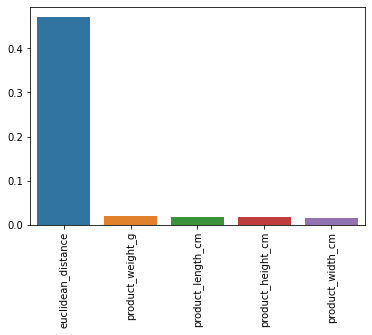

In [30]:
# print the feature importance for the best tree
feature_names = numerical_features + categorical_features
best_tree = prune_pipe.named_steps['gridsearchcv'].best_estimator_
feat_imps = list(zip(feature_names, best_tree.feature_importances_))
feats, imps = zip(*(sorted(list(filter(lambda x:x[1]!=0, feat_imps)), key=lambda x:x[1], reverse=True)))
ax = sns.barplot(list(feats), list(imps))
ax.tick_params(axis='x', rotation=90)

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf_pipe = make_pipeline(preprocess, RandomForestClassifier())
rf_pipe.fit(dev_X, dev_y)

print(rf_pipe.score(dev_X, dev_y))
print(rf_pipe.score(test_X, test_y))
# Default Random Forest still overfitting

0.9997169506146215
0.3256779341204378


In [32]:
# tune the randomforest model
n_estimators = [10, 20, 40, 60, 100]
max_depths = [5, 10, 15, 20, 25]
params = {"n_estimators": n_estimators, "max_depth": max_depths}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=params)
grid_search_rf.fit(preprocess.transform(dev_X), dev_y)
print("Random Forest Dev Accuracy: ", grid_search_rf.score(preprocess.transform(dev_X), dev_y))
print("Random Forest Test Accuracy: ", grid_search_rf.score(preprocess.transform(test_X), test_y))
print("Best Params: ", grid_search_rf.best_params_)
# the result is worse than the default

Random Forest Dev Accuracy:  0.2846802889799439
Random Forest Test Accuracy:  0.23224971696587418
Best Params:  {'max_depth': 25, 'n_estimators': 20}


In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import time
from xgboost import XGBClassifier
params = {'n_estimators': [20, 25, 30, 35, 40],
          'learning_rate': [0.001, 0.01, 0.1],
          'max_depth': [2, 4, 10, 15]}
xgb_pipe = make_pipeline(preprocess, GridSearchCV(XGBClassifier(random_state=42), 
                                                  param_grid=params, cv=5, n_jobs=-1))
# start = time.time()
xgb_pipe.fit(dev_X, dev_y)
# end = time.time()
# print("XGBoost time taken:", end-start)
grid_search_results = xgb_pipe.named_steps['gridsearchcv']
print(f'Best Score:',grid_search_results.best_score_)
print(f'Best Params:',grid_search_results.best_params_)
print(f'Test score:',xgb_pipe.score(test_X, test_y))

/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/

[23:56:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Score: 0.3363840077777436
Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 40}
Test score: 0.33672974284327994


/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/

[22:56:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:56:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

[22:56:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:56:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/

[22:56:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:56:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/

[22:56:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:56:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/

[22:56:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:56:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/

[22:56:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:56:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/

[22:56:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:56:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/

[22:56:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:56:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chuwen/opt/anaconda3/envs/kaggle/lib/

In [34]:
# take majority vote of these three models
from sklearn.ensemble import VotingClassifier
eclf2 = VotingClassifier(estimators=[
         ('decisin tree', best_tree), ('rf', rf_pipe[-1]), ('xgb', xgb_pipe.named_steps['gridsearchcv'].best_estimator_)],
         voting='soft')
major_pipe = make_pipeline(preprocess, eclf2)
major_pipe.fit(dev_X, dev_y)
print(major_pipe.score(dev_X, dev_y))
print(major_pipe.score(test_X, test_y))


[06:22:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9267710804399396
0.33775405682247023


The final model we build got 33.78% accuracy, which is much better than the provided estimation which only has 5.6461%.